In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from sklearn.utils import shuffle
from wordcloud import WordCloud
%matplotlib inline
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense,Activation,Lambda,Input,Embedding,LSTM

In [8]:
df=pd.read_csv('/content/hindi_english_parallel.csv')
print(df.head())

                                               hindi  \
0    अपने अनुप्रयोग को पहुंचनीयता व्यायाम का लाभ दें   
1                    एक्सेर्साइसर पहुंचनीयता अन्वेषक   
2              निचले पटल के लिए डिफोल्ट प्लग-इन खाका   
3               ऊपरी पटल के लिए डिफोल्ट प्लग-इन खाका   
4  उन प्लग-इनों की सूची जिन्हें डिफोल्ट रूप से नि...   

                                          english  
0  Give your application an accessibility workout  
1               Accerciser Accessibility Explorer  
2  The default plugin layout for the bottom panel  
3     The default plugin layout for the top panel  
4  A list of plugins that are disabled by default  


In [9]:
print(len(df))

1561841


In [10]:
# Dropping null values and resetting the index
df.dropna(inplace=True)
df=df.reset_index(drop=True)

In [11]:
df.isnull().sum()

,0
hindi,0
english,0


In [12]:
len(df)

1555574

In [13]:
df['english']

,english
0,Give your application an accessibility workout
1,Accerciser Accessibility Explorer
2,The default plugin layout for the bottom panel
3,The default plugin layout for the top panel
4,A list of plugins that are disabled by default
...,...
1555569,शपथ लेने/प्रतिज्ञान करने वाले सदस्य
1555570,स्पष्टीकरण.–जहां इस उपधारा के अधीन हानि और लाभ...
1555571,है। I note that this is a landmark meeting – n...
1555572,है। In the presentations that they made before...


In [14]:
import re

def is_clean_sentence(en, hi):
    # Lowercase English for pattern matching
    en_l = en.lower()
    hi_l = hi.lower()

    # ❌ patterns that indicate PO / UI noise
    noise_patterns = [
        r'gnome', r'gtk', r'lib', r'\.po',
        r'#-#', r'args', r'%s', r'%d',
        r'\{.*?\}', r'\[.*?\]'
    ]

    for pat in noise_patterns:
        if re.search(pat, en_l) or re.search(pat, hi_l):
            return False

    # ❌ remove sentences with too many symbols
    if len(re.findall(r'[^a-zA-Z\u0900-\u097F\s]', en)) > 3:
        return False
    if len(re.findall(r'[^\u0900-\u097F\s]', hi)) > 3:
        return False

    # ❌ remove very short phrases
    if len(en.split()) < 3 or len(hi.split()) < 3:
        return False

    return True


# Apply cleaning
before = len(df)

df = df[df.apply(lambda x: is_clean_sentence(x['english'], x['hindi']), axis=1)]

after = len(df)

print("Removed noisy sentence pairs:", before - after)
print("Remaining clean dataset size:", after)


Removed noisy sentence pairs: 861692
Remaining clean dataset size: 693882


In [15]:
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [16]:
import re

# Hindi (Devanagari) characters
def contains_hindi(text):
    return bool(re.search(r'[\u0900-\u097F]', str(text)))

# English (Latin) characters
def contains_english(text):
    return bool(re.search(r'[a-zA-Z]', str(text)))


In [17]:
df_clean = df[
    (~df["english"].apply(contains_hindi)) &   # English sentence has NO Hindi chars
    (~df["hindi"].apply(contains_english))     # Hindi sentence has NO English chars
].reset_index(drop=True)

print("Original size :", len(df))
print("Cleaned size  :", len(df_clean))


Original size : 693882
Cleaned size  : 679212


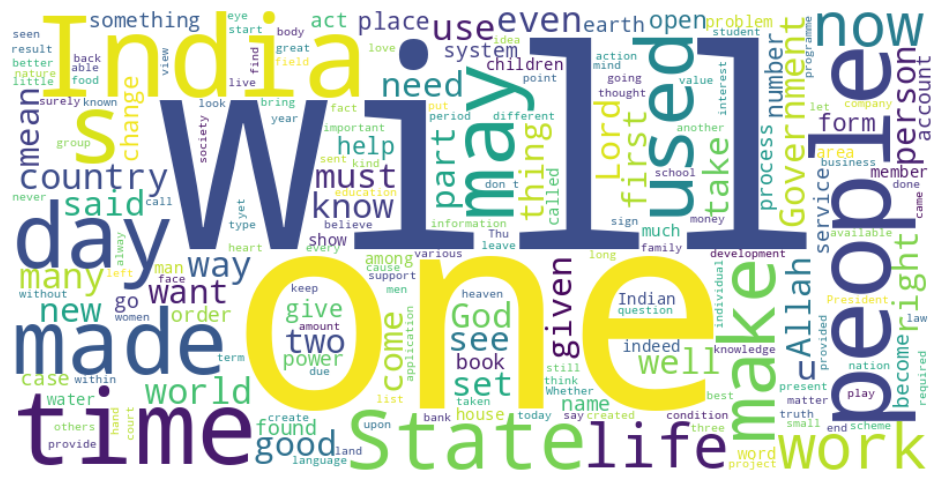

In [18]:
import re
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Make sure to use the correct column name for English
corpus_list = []
for line in df['english']:   # change 'english' to your actual column name
    cleaned_line = re.sub(r'[^A-Za-z\s]', '', str(line))  # keep only English letters
    cleaned_line = ' '.join(cleaned_line.split())          # remove extra spaces
    corpus_list.append(cleaned_line)

corpus = ' '.join(corpus_list)

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(corpus)

plt.figure(figsize=(13,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [19]:
Embedding_dim=100
Latent_dim=400
max_seq_len=100
max_vocab_size=35000

In [20]:
# As the data size is large we will work with 20000 sentences
input_text=[]
target_text=[]
target_text_input=[]
translation=[]
i=19999
for j,t in enumerate(df['english']):
    input_text.append(t)
    if j==i:
        j=0
        break
for j,t in enumerate(df['hindi']):
    translation.append(t)
    target_text.append(t+' <eos>')
    target_text_input.append('<sos> '+t)
    if j==i:
        break

In [21]:
#Input
tokenizer_input=Tokenizer(num_words=max_vocab_size)
tokenizer_input.fit_on_texts(input_text)
tokenized_input=tokenizer_input.texts_to_sequences(input_text)

In [22]:
word2idx=tokenizer_input.word_index
print('word2idx length:',len(word2idx))

word2idx length: 2382


In [23]:
#Output
tokenizer_output=Tokenizer(num_words=max_vocab_size,filters='')
tokenizer_output.fit_on_texts(target_text_input+target_text)
tokenized_target=tokenizer_output.texts_to_sequences(target_text)              #target output
tokenized_target_input=tokenizer_output.texts_to_sequences(target_text_input)  #teacher forcing

In [24]:
word2idx_output=tokenizer_output.word_index
print('length of word2idx output:',len(word2idx_output))
num_words_output=len(word2idx_output)+1

length of word2idx output: 3035


In [25]:
import zipfile

# Extract the zip
with zipfile.ZipFile("/content/glove.6B.100d.txt.zip", 'r') as zip_ref:
    zip_ref.extractall("/content/")

# Now read the extracted file
word_vec = {}
with open("/content/glove.6B.100d.txt", encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        word_vec[word] = vector

print('length of word vector =', len(word_vec))

length of word vector = 400000


In [26]:
#Input
encoder_input=pad_sequences(tokenized_input,maxlen=max_seq_len)
print('Encoder input shape=',encoder_input.shape)

Encoder input shape= (20000, 100)


In [27]:
#target output as input for teacher forcing
decoder_input=pad_sequences(tokenized_target_input,maxlen=max_seq_len,padding='post')
print('decoder input shape:',decoder_input.shape)

decoder input shape: (20000, 100)


In [28]:
#target output
decoder_output=pad_sequences(tokenized_target,maxlen=max_seq_len,padding='post')
print('decoder output shape:',decoder_output.shape)

decoder output shape: (20000, 100)


In [29]:
#creating count matrix
num_words=min(max_vocab_size,len(word2idx)+1)
word_embedding=np.zeros((num_words,Embedding_dim))
for word,i in word2idx.items():
    if i<max_vocab_size:
        vec=word_vec.get(word)
        if vec is not None:
            word_embedding[i]=vec
print('shape of word_embedding:',word_embedding.shape)

shape of word_embedding: (2383, 100)


In [30]:
embedding_layer_input=Embedding(num_words,
                          Embedding_dim,
                          weights=[word_embedding],
                          trainable=True)

In [31]:
import  tensorflow as tf
# Encoder (attention-ready)
encoder_input_placeholder = Input(shape=(max_seq_len,))
x = embedding_layer_input(encoder_input_placeholder)

encoder_lstm = LSTM(
    Latent_dim,
    return_sequences=True,   # 🔥 REQUIRED for attention
    return_state=True
)

encoder_outputs, h, c = encoder_lstm(x)
encoder_states = [h, c]


In [32]:
# Encoder model for INFERENCE (REQUIRED because of attention)
encoder_model = Model(
    encoder_input_placeholder,
    [encoder_outputs, h, c]
)


In [33]:
# Decoder (with attention)
decoder_input_placeholder = Input(shape=(max_seq_len,))
decoder_embedding = Embedding(num_words_output, Embedding_dim)
x = decoder_embedding(decoder_input_placeholder)

decoder_lstm = LSTM(Latent_dim, return_state=True, return_sequences=True)
decoder_outputs, _, _ = decoder_lstm(x, initial_state=encoder_states)

# 🔥 ATTENTION MECHANISM
attention = tf.keras.layers.Attention()
context_vector = attention([decoder_outputs, encoder_outputs])

# 🔥 Combine decoder output with attention context
decoder_outputs = tf.keras.layers.Concatenate(axis=-1)(
    [decoder_outputs, context_vector]
)

decoder_dense = Dense(num_words_output, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)


In [34]:
model=Model([encoder_input_placeholder,decoder_input_placeholder],      # Teacher Forcing
            decoder_outputs)

In [35]:
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [36]:
hist=model.fit([encoder_input,decoder_input],
               decoder_output,
               epochs=250,
               validation_split=0.2,
               batch_size=32)

Epoch 1/250
500/500 ━━━━━━━━━━━━━━━━━━━━ 35s 56ms/step - accuracy: 0.9261 - loss: 0.7530 - val_accuracy: 0.9385 - val_loss: 0.4769
Epoch 2/250
500/500 ━━━━━━━━━━━━━━━━━━━━ 28s 55ms/step - accuracy: 0.9534 - loss: 0.2619 - val_accuracy: 0.9432 - val_loss: 0.4317
Epoch 3/250
500/500 ━━━━━━━━━━━━━━━━━━━━ 28s 57ms/step - accuracy: 0.9705 - loss: 0.1423 - val_accuracy: 0.9478 - val_loss: 0.4175
Epoch 4/250
500/500 ━━━━━━━━━━━━━━━━━━━━ 29s 59ms/step - accuracy: 0.9849 - loss: 0.0745 - val_accuracy: 0.9525 - val_loss: 0.4113
Epoch 5/250
500/500 ━━━━━━━━━━━━━━━━━━━━ 29s 58ms/step - accuracy: 0.9925 - loss: 0.0410 - val_accuracy: 0.9556 - val_loss: 0.4115
Epoch 6/250
500/500 ━━━━━━━━━━━━━━━━━━━━ 29s 58ms/step - accuracy: 0.9957 - loss: 0.0247 - val_accuracy: 0.9571 - val_loss: 0.4190
Epoch 7/250
500/500 ━━━━━━━━━━━━━━━━━━━━ 31s 62ms/step - accuracy: 0.9971 - loss: 0.0167 - val_accuracy: 0.9581 - val_loss: 0.4239
Epoch 8/250
500/500 ━━━━━━━━━━━━━━━━━━━━ 29s 58ms/step - accuracy: 0.9979 - loss: 0

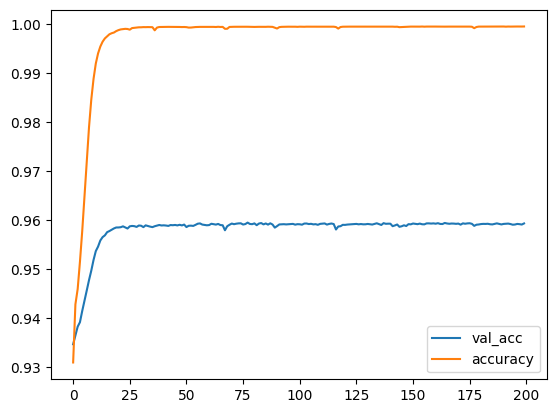

In [ ]:
plt.plot(hist.history['val_accuracy'],label='val_acc')
plt.plot(hist.history['accuracy'],label='accuracy')
plt.legend()

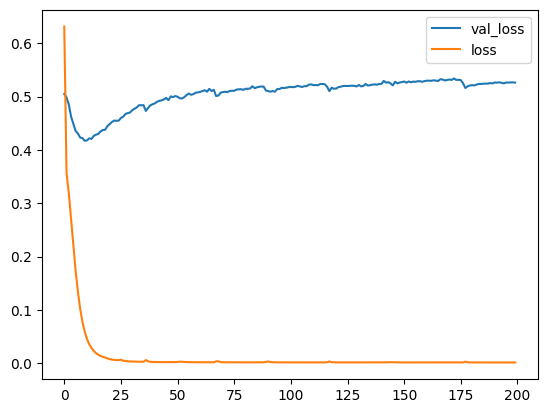

In [ ]:
plt.plot(hist.history['val_loss'],label='val_loss')
plt.plot(hist.history['loss'],label='loss')
plt.legend()

In [ ]:
encoder_model=Model(encoder_input_placeholder,encoder_states)

In [44]:
from tensorflow.keras.layers import Concatenate

# Decoder for prediction (one step at a time)

decoder_inital_h = Input(shape=(Latent_dim,))
decoder_inital_c = Input(shape=(Latent_dim,))
decoder_initial_states = [decoder_inital_h, decoder_inital_c]

# Encoder outputs needed for attention
encoder_outputs_inf = Input(shape=(max_seq_len, Latent_dim))

decoder_input_single = Input(shape=(1,))
decoder_embedding_single = decoder_embedding(decoder_input_single)

decoder_outputs_x, h, c = decoder_lstm(
    decoder_embedding_single,
    initial_state=decoder_initial_states
)

# 🔥 ATTENTION (same as training)
context_vector = attention([decoder_outputs_x, encoder_outputs_inf])

# 🔥 Concatenate (to match training shape = 800)
decoder_combined = Concatenate(axis=-1)(
    [decoder_outputs_x, context_vector]
)

decoder_output = decoder_dense(decoder_combined)

decoder_states = [h, c]

decoder_model = Model(
    [decoder_input_single, encoder_outputs_inf] + decoder_initial_states,
    [decoder_output] + decoder_states
)


In [45]:
idx2word_output={v:k for k,v in word2idx_output.items()}

In [46]:
def sample_with_temperature(probs, temperature=0.7):
    probs = np.asarray(probs).astype("float64")
    probs = np.log(probs + 1e-9) / temperature
    probs = np.exp(probs) / np.sum(np.exp(probs))
    return np.random.choice(len(probs), p=probs)


In [47]:
def decode_sequence(input_seq):
    # Encode the input sequence
    encoder_outputs, h, c = encoder_model.predict(input_seq)

    # <sos> token
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = tokenizer_output.word_index['<sos>']

    decoded_sentence = []

    for _ in range(max_seq_len):
        output_tokens, h, c = decoder_model.predict(
            [target_seq, encoder_outputs, h, c]   # 🔥 PASS encoder_outputs
        )

        sampled_token_index = sample_with_temperature(
        output_tokens[0, -1, :], temperature=0.7
               )



        sampled_word = tokenizer_output.index_word.get(sampled_token_index, '')

        if sampled_word == '<eos>' or sampled_word == '':
            break

        decoded_sentence.append(sampled_word)

        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

    return ' '.join(decoded_sentence)


In [48]:
print(len(encoder_model.outputs))
print(encoder_model.outputs)


3
[<KerasTensor shape=(None, 100, 400), dtype=float32, sparse=False, ragged=False, name=keras_tensor_2>, <KerasTensor shape=(None, 400), dtype=float32, sparse=False, ragged=False, name=keras_tensor_3>, <KerasTensor shape=(None, 400), dtype=float32, sparse=False, ragged=False, name=keras_tensor_4>]


In [49]:
print(len(encoder_model.outputs))
print(encoder_model.output)


3
[<KerasTensor shape=(None, 100, 400), dtype=float32, sparse=False, ragged=False, name=keras_tensor_2>, <KerasTensor shape=(None, 400), dtype=float32, sparse=False, ragged=False, name=keras_tensor_3>, <KerasTensor shape=(None, 400), dtype=float32, sparse=False, ragged=False, name=keras_tensor_4>]


In [50]:
i=0
while i<10:
    j=np.random.choice(len(encoder_input))
    input_seq=encoder_input[j:j+1]
    seq=decode_sequence(input_seq)
    print('------------------')
    print('input text:',input_text[j])
    print('real output',translation[j])
    print('predicted output:',seq)
    i+=1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
------------------
input text: Toggle bookmark at the current line position
real output टॉगल एट लकीर स्थिति
predicted output: टॉगल एट लकीर स्थिति
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
------------------
input text: Timestamp of the current fontconfig configuration
real output मौजूदा फ़ॉन्टकॉन्फ़िग विन्यास का टाइमस्टैंप
predicted output: मौजूदा फ़ॉन्टकॉन्फ़िग विन्यास का टाइमस्टैंप
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━

In [51]:
# Number of samples to evaluate
num_samples = 50

# Randomly select indices
sample_indices = np.random.choice(len(encoder_input), num_samples, replace=False)

# Generate predictions
predicted_outputs = []
for idx in sample_indices:
    input_seq = encoder_input[idx:idx+1]
    pred = decode_sequence(input_seq)
    predicted_outputs.append(pred)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━

In [52]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import re

smooth = SmoothingFunction().method5

def clean_text(text):
    text = text.lower().strip()
    text = re.sub(r"[^\w\s]", "", text)
    return text

bleu_scores = []
for ref, pred in zip([translation[i] for i in sample_indices], predicted_outputs):
    ref_clean = clean_text(ref)
    pred_clean = clean_text(pred)

    bleu = sentence_bleu(
        [ref_clean.split()],
        pred_clean.split(),
        weights=(0.5, 0.5, 0, 0),
        smoothing_function=smooth
    )
    bleu_scores.append(bleu)

avg_bleu = sum(bleu_scores) / len(bleu_scores)
print(f"Average BLEU: {avg_bleu:.4f}")


Average BLEU: 0.9741
